In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HEIVkitsKN5GrtOiJhcI")
project = rf.workspace("five-defects").project("yes_defects")
version = project.version(3)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


# 1. Import dataset from Roboflow where we can just straight download code snippet and integrate

![image.png](attachment:bb92ea3b-6dcf-4148-aee1-3447317ed90b.png)
![image.png](attachment:190da870-058c-41f4-91bb-92ba63c28568.png)

# 2. Setting Up Dataset

## Defining Dataset Class (Resizing, Reduce Ratio)

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import os
import random
import numpy as np
from PIL import Image, ImageFilter

class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation_file, transforms=None, img_size=None, reduce_ratio=None):
        """
        Args:
            root (str): Path to the image directory.
            annotation_file (str): Path to the COCO JSON annotation file.
            transforms (callable, optional): Transformations applied to images.
            img_size (tuple, optional): Target image size (width, height).
            reduce_ratio (float, optional): Ratio to reduce the dataset. If None, no reduction.
        """

        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.img_size = img_size  # (width, height), or None for no resizing

        # Reduce dataset by ratio if specified
        if reduce_ratio:
            self.reduce_dataset(reduce_ratio)

    def reduce_dataset(self, ratio):
        """
        Reduces the dataset size by the specified ratio.
        Args:
            ratio (float): Ratio to reduce the dataset, e.g., 0.5 means keep half the data.
        """
        num_samples = len(self.ids)
        num_samples_to_keep = int(num_samples * ratio)
        self.ids = random.sample(self.ids, num_samples_to_keep)
        print(f"Reduced dataset to {num_samples_to_keep} samples (from {num_samples}).")


    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        image = Image.open(img_path).convert("RGB")


        # Original image size
        orig_w, orig_h = img_info["width"], img_info["height"]

        # Resize image if needed
        if self.img_size:
            new_w, new_h = self.img_size
            image = F.resize(image, (new_h, new_w))
            scale_x = new_w / orig_w
            scale_y = new_h / orig_h
        else:
            scale_x, scale_y = 1.0, 1.0

        if self.transforms:
            image = self.transforms(image)


        # Scale bounding boxes accordingly
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            xmin = x * scale_x
            ymin = y * scale_y
            xmax = (x + w) * scale_x
            ymax = (y + h) * scale_y

            # Ensure valid bounding boxes
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(ann["category_id"])
            else:
                print(f"Warning: Invalid bbox {xmin, ymin, xmax, ymax} removed.")

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}
        return image, target

    def __len__(self):
        return len(self.ids)


## Defining Data Augmentation Class (need to transform both image and bbox, torchvision.transform only transform image)

In [134]:
class BboxAugmentation:
    def __init__(self,
                 flip_prob=0.5,
                 max_shift=0.1,
                 max_rotate=15,
                 brightness=None,
                 contrast=None):
        self.flip_prob = flip_prob
        self.max_shift = max_shift  # Fraction of image size
        self.max_rotate = max_rotate  # Degrees
        self.brightness = brightness
        self.contrast = contrast
        self._is_tensor = False  # Track if input is tensor

    def __call__(self, image, target):
        # Track if input is tensor
        self._is_tensor = isinstance(image, torch.Tensor)

        # Convert tensor to PIL if needed
        if self._is_tensor:
            image = F.to_pil_image(image)

        # Get image dimensions
        w, h = image.size

        # Apply augmentations in sequence
        if random.random() < self.flip_prob:
            image, target = self.horizontal_flip(image, target)

        if random.random() < 0.5:
            shift_x = random.uniform(-self.max_shift, self.max_shift) * w
            shift_y = random.uniform(-self.max_shift, self.max_shift) * h
            image, target = self.shift(image, target, shift_x, shift_y)

        if random.random() < 0.5:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            image, target = self.rotate(image, target, angle)

        # Convert back to tensor if original was tensor
        if self._is_tensor:
            image = F.to_tensor(image)

        return image, target

    def horizontal_flip(self, image, target):
        image = F.hflip(image)
        w = image.width

        # Flip bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # x1 = w - x2, x2 = w - x1
        target["boxes"] = boxes

        return image, target

    def shift(self, image, target, shift_x, shift_y):
        # Apply affine transformation
        image = F.affine(
            image,
            angle=0,
            translate=(int(shift_x), int(shift_y)),
            scale=1.0,
            shear=0
        )

        # Shift bounding boxes
        boxes = target["boxes"].clone()
        boxes[:, [0, 2]] += shift_x  # x coordinates
        boxes[:, [1, 3]] += shift_y  # y coordinates

        # Clip boxes to image boundaries
        boxes[:, 0::2].clamp_(min=0, max=image.width)
        boxes[:, 1::2].clamp_(min=0, max=image.height)

        # Remove boxes that became invalid
        valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        target["boxes"] = boxes[valid_boxes]
        target["labels"] = target["labels"][valid_boxes]

        return image, target

    def rotate(self, image, target, angle):
        # Convert to tensor to get dimensions
        img_tensor = F.to_tensor(image)
        h, w = img_tensor.shape[-2:]

        # Rotate image
        image = F.rotate(image, angle, expand=False)

        # Convert boxes to polygons, rotate, then back to boxes
        boxes = target["boxes"].clone()
        polygons = []
        for box in boxes:
            x1, y1, x2, y2 = box
            # Create polygon coordinates
            poly = np.array([
                [x1, y1], [x2, y1], [x2, y2], [x1, y2]
            ])
            polygons.append(poly)

        # Rotate polygons
        center = (w/2, h/2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_polys = []
        for poly in polygons:
            # Add ones for homogeneous coordinates
            poly_homo = np.column_stack((poly, np.ones(4)))
            rotated_poly = np.dot(rot_mat, poly_homo.T).T
            rotated_polys.append(rotated_poly)

        # Convert back to boxes
        new_boxes = []
        for poly in rotated_polys:
            x_coords = poly[:, 0]
            y_coords = poly[:, 1]
            new_box = [
                max(0, min(x_coords)),
                max(0, min(y_coords)),
                min(w, max(x_coords)),
                min(h, max(y_coords))
            ]
            new_boxes.append(new_box)

        new_boxes = torch.tensor(new_boxes, dtype=torch.float32)

        # Filter invalid boxes
        valid_boxes = (new_boxes[:, 2] > new_boxes[:, 0]) & (new_boxes[:, 3] > new_boxes[:, 1])
        target["boxes"] = new_boxes[valid_boxes]
        target["labels"] = target["labels"][valid_boxes]

        return image, target

In [135]:
# Wrap your dataset with augmentation
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, bbox_augment, transforms=None):
        self.dataset = dataset  # Original dataset
        self.bbox_augment = bbox_augment  # Augmentation class
        self.transforms = transforms  # Optional normalization transform

    def __getitem__(self, idx):
        image, target = self.dataset[idx]
        # Apply augmentation to the image and target
        augmented_image, augmented_target = self.bbox_augment(image, target)

        # Apply normalization if a transform is provided
        if self.transforms:
            augmented_image = self.transforms(augmented_image)

        return augmented_image, augmented_target

    def __len__(self):
        return len(self.dataset)


## Compute the Datasets Normalization value (mean and std for your dataset)

In [108]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from tqdm import tqdm

##############CHANG TO YOUR PATH#################

root_dir = "/content/yes_defects-3"

##############CHANG TO YOUR PATH#################

train_dir = os.path.join(root_dir, "train")
valid_dir = os.path.join(root_dir, "valid")
test_dir = os.path.join(root_dir, "test")

train_json = os.path.join(train_dir, "_annotations.coco.json")
valid_json = os.path.join(valid_dir, "_annotations.coco.json")
test_json = os.path.join(test_dir, "_annotations.coco.json")

# 1. Create basic dataset with only ToTensor transform
temp_dataset = CustomCocoDataset(
    root=train_dir,
    annotation_file=train_json,
    transforms=T.ToTensor(),  # Only this transform
    img_size=None,  # Don't resize yet
    reduce_ratio=None
)

# 2. Compute stats directly
pixel_sum = torch.zeros(3)
pixel_sq_sum = torch.zeros(3)
num_pixels = 0

for img, _ in temp_dataset:  # Direct iteration (no DataLoader)
    pixel_sum += img.sum(dim=[1, 2])  # Sum over height and width
    pixel_sq_sum += (img**2).sum(dim=[1, 2])
    num_pixels += img.shape[1] * img.shape[2]

Calculatedmean = pixel_sum / num_pixels
Calculatedstd = (pixel_sq_sum / num_pixels - Calculatedmean**2).sqrt()

print(f"Mean: {Calculatedmean.tolist()}")
print(f"Std: {Calculatedstd.tolist()}")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Mean: [0.20383122563362122, 0.18635477125644684, 0.214472696185112]
Std: [0.24466532468795776, 0.2258015275001526, 0.24685510993003845]


## Data Augmentation + Loading into dataloader

In [142]:
batch_size=16
num_workers=2
pin_memory=True
collate_fn=lambda x: tuple(zip(*x))

# Now define actual transforms with computed values
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=Calculatedmean, std=Calculatedstd)
])

def load_data(data_augmentation=False):

    if data_augmentation: #When data_augmentation is true
        original_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

        Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5
        )

        # Create augmentation instance
        bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

        augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

        #merging Two datasets
        train_dataset = torch.utils.data.ConcatDataset([original_dataset,augmented_dataset])

    else: #when Data augmentation is False
        train_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
        )

    valid_dataset = CustomCocoDataset(
            root=valid_dir,
            annotation_file=valid_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    test_dataset = CustomCocoDataset(
            root=test_dir,
            annotation_file=test_json,
            transforms=transforms,
            img_size=(224, 224),
            reduce_ratio=None
    )

    #Put them into Data loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False ,
        num_workers=num_workers ,
        pin_memory=pin_memory,
        collate_fn=collate_fn
    )

    return train_dataset , valid_dataset, test_dataset, train_loader, valid_loader , test_loader


### With Augmentation

In [143]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader= load_data(data_augmentation=True)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Reduced dataset to 1525 samples (from 3050).
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=10.47s)
creating index...
index created!
Number of images in training set: 4575
Number of images in validation set: 1005
Number of images in test set: 1006


### Without Augmentation

In [95]:
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = load_data(data_augmentation=False)

train_images = len(train_loader.dataset)
valid_images = len(valid_loader.dataset)
test_images = len(test_loader.dataset)

print(f'Number of images in training set: {train_images}')
print(f'Number of images in validation set: {valid_images}')
print(f'Number of images in test set: {test_images}')

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of images in training set: 3050
Number of images in validation set: 1005
Number of images in test set: 1006


## DEfine Classes NAME (Choose one of the method you find it suitable)

### 1. Automated script to extract classes (this method i take out index[0] because it contain the class name i dont need ('defects')

In [ ]:
#import json

# Load your annotation file
#################CHANGE TO YOUR PATH#######################################

with open('/kaggle/working/yes_defects-3/test/_annotations.coco.json') as f:

#################CHANGE TO YOUR PATH#######################################

    data = json.load(f)

# Extract class names (sorted by category_id)
CLASS_NAMES = [
    category['name'] for category in sorted(data['categories'], key=lambda x: x['id'])
    if category['id'] != 0  # Exclude category with ID 0
]
CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx + 1: cls_name for idx, cls_name in enumerate(CLASS_NAMES)}  # Reverse mapping

print(CLASS_NAMES)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Index to Class Mapping:", IDX_TO_CLASS)

['M_adhesion', 'M_tear', 'POB_marginal', 'POB_unacceptable', 'U_adhesion', 'U_tear', 'dent_marginal', 'dent_unacceptable', 'scuff_marginal', 'scuff_unacceptable']
Class to Index Mapping: {'M_adhesion': 1, 'M_tear': 2, 'POB_marginal': 3, 'POB_unacceptable': 4, 'U_adhesion': 5, 'U_tear': 6, 'dent_marginal': 7, 'dent_unacceptable': 8, 'scuff_marginal': 9, 'scuff_unacceptable': 10}
Index to Class Mapping: {1: 'M_adhesion', 2: 'M_tear', 3: 'POB_marginal', 4: 'POB_unacceptable', 5: 'U_adhesion', 6: 'U_tear', 7: 'dent_marginal', 8: 'dent_unacceptable', 9: 'scuff_marginal', 10: 'scuff_unacceptable'}


### 2. Hardcode way to get the classes name (do this if you know exactly what are the classes name)

In [ ]:
# Define class labels and mapping
#Reason to hardcord is if you use automa

####################CHANGE TO YOUR DATASET CLASSES NAME##############################################

CLASS_NAMES = [
    "M_adhesion", "M_tear", "POB_marginal", "POB_unacceptable", "U_adhesion",
    "U_tear", "dent_marginal", "dent_unacceptable", "scuff_marginal", "scuff_unacceptable"
]

####################CHANGE TO YOUR DATASET CLASSES NAME##############################################

CLASS_TO_IDX = {cls_name: idx + 1 for idx, cls_name in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx + 1: cls_name for idx, cls_name in enumerate(CLASS_NAMES)}  # Reverse mapping

# Print mappings (optional)
print("Class to Index Mapping:", CLASS_TO_IDX)
print("Index to Class Mapping:", IDX_TO_CLASS)


Class to Index Mapping: {'M_adhesion': 1, 'M_tear': 2, 'POB_marginal': 3, 'POB_unacceptable': 4, 'U_adhesion': 5, 'U_tear': 6, 'dent_marginal': 7, 'dent_unacceptable': 8, 'scuff_marginal': 9, 'scuff_unacceptable': 10}
Index to Class Mapping: {1: 'M_adhesion', 2: 'M_tear', 3: 'POB_marginal', 4: 'POB_unacceptable', 5: 'U_adhesion', 6: 'U_tear', 7: 'dent_marginal', 8: 'dent_unacceptable', 9: 'scuff_marginal', 10: 'scuff_unacceptable'}


## Visualization with the annotated BBox

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Reduced dataset to 1525 samples (from 3050).


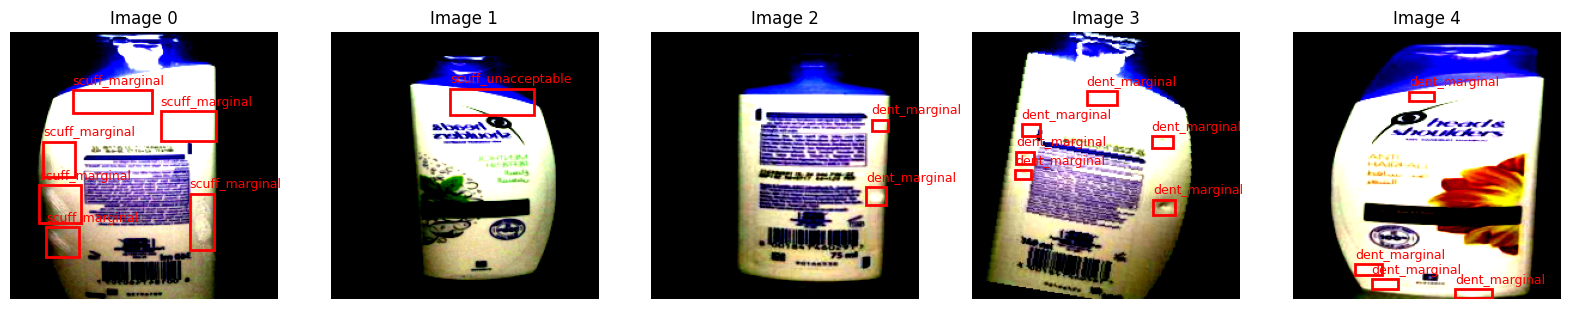

In [127]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image

Tobeaugmented_dataset = CustomCocoDataset(
            root=train_dir,
            annotation_file=train_json,
            transforms=None,
            img_size=(224, 224),
            reduce_ratio=0.5
        )

        # Create augmentation instance
bbox_augment = BboxAugmentation(
            flip_prob=0.5,
            max_shift=0.1,
            max_rotate=15
        )

augmented_dataset = AugmentedDataset(Tobeaugmented_dataset, bbox_augment, transforms=transforms)

# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()


# Visualize images from the training dataset
visualize_batch(augmented_dataset)


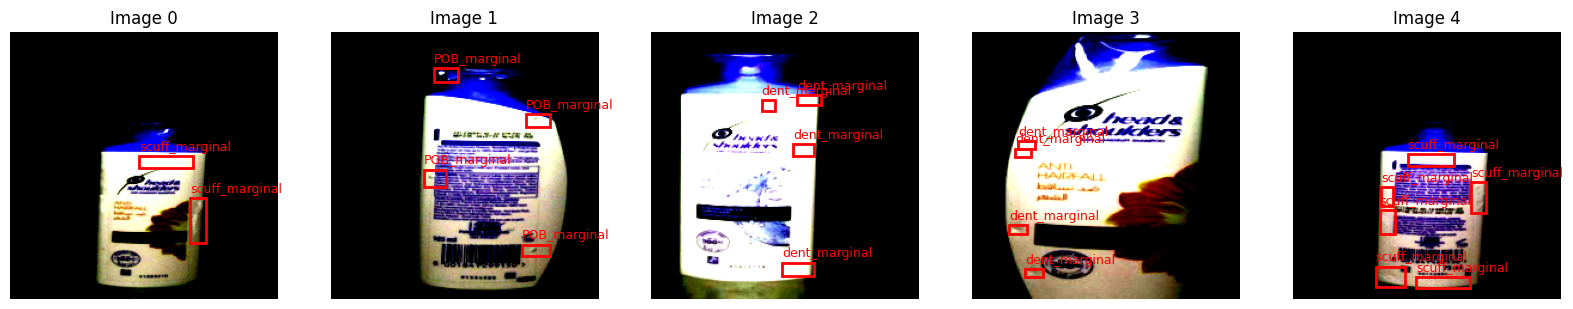

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from matplotlib import patches
from PIL import Image



# Function to visualize a batch of images with bounding boxes and variable font sizes
def visualize_batch(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i in range(num_images):
        # Get image and target
        image, target = dataset[i]

        # Convert image to tensor if it's not already
        # Normalize image data to the range [0, 1] if it's a tensor
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy format
            image = np.clip(image, 0, 1)  # Clip any values outside the range [0, 1]

        boxes = target["boxes"].numpy()
        labels = target["labels"].numpy()

        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Image {i}")
        ax.axis("off")

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Apply font size based on class label
            class_name = IDX_TO_CLASS[label]  # Get the class name using label
            font_size = 9  # Default font size

            # Example: smaller font size for class 1, larger for others

            ax.text(xmin, ymin - 5, f"{class_name}", color='red', fontsize=font_size)

    plt.show()

# Visualize images from the training dataset
visualize_batch(train_dataset)


# 3. Model Training

## Setting up the model and start Training

In [144]:
import torchvision
import torch.optim as optim

# Define the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(CLASS_NAMES) + 1  # Number of classes + 1 for background
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop with loss visualization
num_epochs = 10
train_losses = []
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Average Loss: {epoch_loss:.4f}\n")

# Plot training loss
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Epoch [1/10], Step [1/286], Loss: 3.6531
Epoch [1/10], Step [2/286], Loss: 1.7778
Epoch [1/10], Step [3/286], Loss: 0.9970
Epoch [1/10], Step [4/286], Loss: 0.7656


KeyboardInterrupt: 

# Save the CheckPoint afterwards

In [ ]:
torch.save(model.state_dict(), f"fasterrcnn_epoch_{epoch+1}.pth")
print(f"Model saved as fasterrcnn_epoch_{epoch+1}.pth")

# 4. Load the Model adn Evaluate

In [ ]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)  # No default weights
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the saved weights
checkpoint_path = "fasterrcnn_epoch_10.pth"  # Update with your checkpoint file name
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()  # Set to evaluation mode

print("Model loaded successfully!")